In [ ]:
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet

Cloning into 'Brain-Tumor-Classification-DataSet'...
remote: Enumerating objects: 3039, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3035
Receiving objects: 100% (3039/3039), 79.25 MiB | 40.02 MiB/s, done.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import pickle
import time
import numpy as np
import keras.optimizers
from sklearn.metrics import classification_report

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import imutils
import cv2
import PIL.Image
import os
%matplotlib inline

demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [ ]:
#make output_dir
import os
output_folders=["glioma_tumor_o","meningioma_tumor_o","no_tumor_o","pituitary_tumor_o"]
def mkdir():
    for output_folder in output_folders:
        os.mkdir(output_folder)
mkdir()



In [ ]:
import os

def mkdir():
    os.mkdir('testfolder')
    os.mkdir('testfolder1')
    os.mkdir('testfolder_output')
    os.mkdir('testfolder_output1')

mkdir()


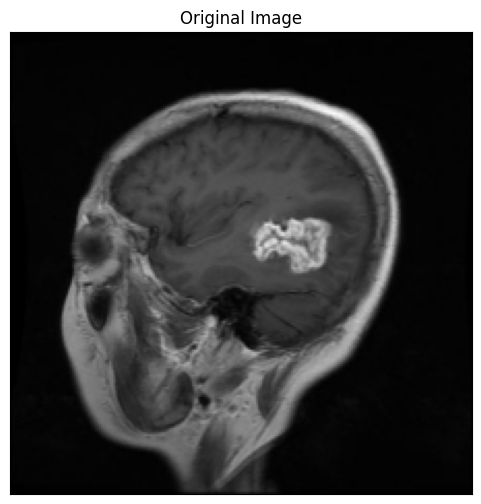

In [ ]:
import os
import cv2
import imutils
import matplotlib.pyplot as plt

def cropAndAugmentation():
    flag1 = 0
    flag2 = 0
    j = 0
    IMG_SIZE = 224
    dim = (IMG_SIZE, IMG_SIZE)

    cwd = os.getcwd()
    directory = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
    directory_output = ["glioma_tumor_o", "meningioma_tumor_o", "no_tumor_o", "pituitary_tumor_o"]
    desired_folder = "Brain-Tumor-Classification-DataSet/Training/"

    for input_folder in directory:
        for output_folder in directory_output:
            input_folder_path = os.path.join(cwd, desired_folder+input_folder)  # Construct input folder path
            output_folder_path = os.path.join(cwd, desired_folder+output_folder)  # Construct output folder path
            if not os.path.exists(input_folder_path):
                raise FileNotFoundError(f"Input folder {input_folder_path} does not exist.")

            for img in os.listdir(input_folder_path):
                image_path = os.path.join(input_folder_path, img)  # Construct full image path
                image = cv2.imread(image_path)
                image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                gray = cv2.GaussianBlur(gray, (5, 5), 0)

                # Printing original image
                if flag1 == 0:
                    plt.figure(figsize=(15, 6))
                    plt.imshow(image)
                    plt.xticks([])
                    plt.yticks([])
                    plt.title('Original Image')
                    plt.show()
                    flag1 = 1


                thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
                thresh = cv2.erode(thresh, None, iterations=2)
                thresh = cv2.dilate(thresh, None, iterations=2)

                cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cnts = imutils.grab_contours(cnts)
                c = max(cnts, key=cv2.contourArea)

                extLeft = tuple(c[c[:, :, 0].argmin()][0])
                extRight = tuple(c[c[:, :, 0].argmax()][0])
                extTop = tuple(c[c[:, :, 1].argmin()][0])
                extBot = tuple(c[c[:, :, 1].argmax()][0])

                img_cnt = cv2.drawContours(image.copy(), [c], -1, (0, 255, 255), 4)

                img_pnt = cv2.circle(img_cnt.copy(), extLeft, 5, (0, 0, 255), -1)
                img_pnt = cv2.circle(img_pnt, extRight, 5, (0, 255, 0), -1)
                img_pnt = cv2.circle(img_pnt, extTop, 5, (255, 0, 0), -1)
                img_pnt = cv2.circle(img_pnt, extBot, 5, (255, 255, 0), -1)

                ADD_PIXELS = 0
                new_image = image[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

                # # Printing cropped image
                # if flag2 == 0:
                #     plt.figure(figsize=(15, 6))
                #     plt.imshow(new_image)
                #     plt.xticks([])
                #     plt.yticks([])
                #     plt.title('Cropped Image')
                #     plt.show()
                #     flag2 = 1

                # # Plot intermediate steps...
                # plt.figure(figsize=(15, 6))
                # plt.subplot(141)
                # plt.imshow(image)
                # plt.xticks([])
                # plt.yticks([])
                # plt.title('Step 1. Original Image')

                # # Draw contours on the image
                # img_cnt = image.copy()  # Make a copy of the original image
                # cv2.drawContours(img_cnt, cnts, -1, (0, 255, 255), 4)  # Draw all contours
                # plt.subplot(142)
                # plt.imshow(img_cnt)
                # plt.xticks([])
                # plt.yticks([])
                # plt.title('Step 2. Contour Detection')

                # plt.subplot(143)
                # plt.imshow(thresh, cmap='gray')
                # plt.xticks([])
                # plt.yticks([])
                # plt.title('Step 3. Threshold Image')

                # plt.subplot(144)
                # plt.imshow(new_image)
                # plt.xticks([])
                # plt.yticks([])
                # plt.title('Step 4. Cropped Image')

                # plt.show()

                x = new_image
                x = x.reshape((1,) + x.shape)
                i = 0

                for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='{}'.format(output_folder), save_prefix='{}_{}'.format(input_folder,j), save_format='jpg'):
                    i += 1
                    if i > 20:
                        break
                j += 1

cropAndAugmentation()


In [ ]:
import os

def count_images(directory):
    total_images = 0
    for root, dirs, files in os.walk(directory):
        total_images += len(files)
    return total_images

training_directory = "/content/Brain-Tumor-Classification-DataSet/Training"
testing_directory = "/content/Brain-Tumor-Classification-DataSet/Testing"

total_training_images = count_images(training_directory)
total_testing_images = count_images(testing_directory)

print("Total number of images in training set:", total_training_images)
print("Total number of images in testing set:", total_testing_images)

In [ ]:
print(count_images("/content/glioma_tumor_o"))

In [ ]:
print(count_images("/content/Brain-Tumor-Classification-DataSet/Training/glioma_tumor"))

In [ ]:
# import os
# import cv2
# import matplotlib.pyplot as plt

# def cropAndAugmentation():
#     # Augmentation Code
#     flag1 = 0
#     flag2 = 0
#     j = 0
#     IMG_SIZE = 224
#     dim = (IMG_SIZE, IMG_SIZE)
#     cwd = os.getcwd()
#     directory = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
#     directory_output = ["glioma_tumor_o", "meningioma_tumor_o", "no_tumor_o", "pituitary_tumor_o"]
#     desired_folder = "Brain-Tumor-Classification-DataSet/Training/"

#     for input_folder in directory:
#         for output_folder in directory_output:
#             input_folder_path = os.path.join(cwd, desired_folder+input_folder)  # Construct input folder path
#             output_folder_path = os.path.join(cwd, desired_folder+output_folder)  # Construct output folder path
#             if not os.path.exists(input_folder_path):
#                 raise FileNotFoundError(f"Input folder {input_folder_path} does not exist.")


#             for img in os.listdir(input_folder_path):
#                 image_path = os.path.join(input_folder_path, img)  # Construct full image path
#                 image = cv2.imread(image_path)  #
#                 image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
#                 # use inter_cubic
#                 gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # convert into gray image
#                 gray = cv2.GaussianBlur(gray, (5, 5), 0)  # blur the image to reduce noise
#                 # print original image
#                 if flag1 == 0:
#                     plt.figure(figsize=(15, 6))
#                     plt.imshow(image)
#                     plt.xticks([])  # to remove tickmarks
#                     plt.yticks([])
#                     plt.title('Step1: Before Crop')
#                     plt.show()
#                     flag1 = 1
#                 # threshold the image, then perform a series of erosion
#                 # 45 min,255 max that means <45 set to 0 and >45 set to 255
#                 thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
#                 thresh = cv2.erode(thresh, None, iterations=2)
#                 thresh = cv2.dilate(thresh, None, iterations=2)
#                 # find contours in thresholded image, then grab the largest one
#                 cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#                # cnts = imutils.grab_contours(cnts)
#                 c = max(cnts, key=cv2.contourArea)
#                  # find the extreme points
#                 extLeft = tuple(c[c[:, :, 0].argmin()][0])
#                 extRight = tuple(c[c[:, :, 0].argmax()][0])
#                 extTop = tuple(c[c[:, :, 1].argmin()][0])
#                 extBot = tuple(c[c[:, :, 1].argmax()][0])
#                 # add contour on the image
#                 #to draw a countores on the image  like border
#                 img_cnt = cv2.drawContours(image.copy(), [c], -1, (0, 255, 255), 4)
#                 # add extreme points
#                 img_pnt = cv2.circle(img_cnt.copy(), extLeft, 5, (0, 0, 255), -1)
#                 img_pnt = cv2.circle(img_pnt, extRight, 5, (0, 255, 0), -1)
#                 img_pnt = cv2.circle(img_pnt, extTop, 5, (255, 0, 0), -1)
#                 img_pnt = cv2.circle(img_pnt, extBot, 5, (255, 255, 0), -1)
#                 # apply crop
#                 ADD_PIXELS = 0
#                 new_image = image[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
#          # print after crop
#                # '''  # Comment this section during execution
#                 if flag2==0:
#                   plt.figure(figsize=(15,6))
#                   plt.imshow(new_image)
#                   plt.xticks([])
#                   plt.yticks([])
#                   plt.title('Step2: After Crop')
#                   plt.show()
#                  #plot_crops()
#                   flag2=1
#                # '''  #Display crops----------------------------------------------------------
#                   #def plot_crops()
#                   # '''  # Comment this section during execution
#                   plt.figure(figsize=(15,6))
#                   plt.subplot(141)
#                   plt.imshow(image)
#                   plt.xticks([])
#                   plt.yticks([])
#                   plt.title('Step 1. Get the original image')
#                   plt.subplot(142)
#                   plt.imshow(img_cnt)
#                   plt.xticks([])
#                   plt.yticks([])
#                   plt.title('Step 2. Find the biggest contour')
#                   plt.subplot(143)
#                   plt.imshow(img_pnt)
#                   plt.xticks([])
#                   plt.yticks([])
#                   plt.title('Step 3. Find the extreme points')
#                   plt.subplot(144)
#                   plt.imshow(new_image)
#                   plt.xticks([])
#                   plt.yticks([])
#                   plt.title('Step 4. Crop the image')
#                   plt.show()
#                    ## AUGMENTATION STARTS HERE---------------------------------------------
#                   x = new_image
#                   #x = cv2.resize(x, dim)
#                   x = x.reshape((1,) + x.shape)
#                   i = 0
#                   # Save data to folder testfolder_output
#                   for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='{}'.format(output_folder), save_prefix='{}_{}'.format(input_folder,j), save_format='jpg'):

#                     i += 1
#                     if i > 20:
#                         break
#                     j+=1
#                   #            # '''  # Comment this section during execution
#                   # plt.imshow(x[0])
#                   # plt.xticks([])
#                   # plt.yticks([])
#                   # plt.title('Original Image')
#                   plt.show()

#                   # plt.figure(figsize=(15,6))

#                   # i = 1
#                   # for img in os.listdir('testfolder_output/'):
#                   #     img = cv2.cv2.imread('testfolder_output/' + img)
#                   #     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#                   #     plt.subplot(3,7,i)
#                   #     plt.imshow(img)
#                   #     plt.xticks([])
#                   #     plt.yticks([])
#                   #     i += 1
#                   #     if i > 3*7:
#                   #         break
#                   # plt.suptitle('Augemented Images')
#                   # plt.show()
#                   # # '''




# cropAndAugmentation()


In [ ]:
# var =([resized_image, rotated_image, flipped_image], ['resized', 'rotated', 'flipped']):
# for processed_image, postfix in var
#     print(processed_image)

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
file="/content/glioma_tumor_o"
len(file)

In [ ]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
flag1 = 0  # Declare flag1 as global variable
flag2 = 0
j = 0


def cropAndAugmentation():
    global flag1  # Declare flag1 as global within the function
    global flag2
    global j
    # Augmentation Code
    IMG_SIZE = 80
    ADD_PIXELS = 5  # Adjust as needed
    dim = (IMG_SIZE, IMG_SIZE)
    cwd = os.getcwd()
    input_folders = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
    output_folders = ["glioma_tumor_o", "meningioma_tumor_o", "no_tumor_o", "pituitary_tumor_o"]
    desired_folder = "Brain-Tumor-Classification-DataSet/Training/"
    for input_folder, output_folder in zip(input_folders, output_folders):
        input_folder_path = os.path.join(cwd, desired_folder + input_folder)  # Construct input folder path
        output_folder_path = os.path.join(cwd, desired_folder + output_folder)  # Construct output folder path
        for img in os.listdir(input_folder_path):
            image_path = os.path.join(input_folder_path, img)
            image = cv2.imread(image_path)
                # Thresholding
            thresh = cv2.threshold(image, 45, 255, cv2.THRESH_BINARY)[1]
            thresh = cv2.erode(thresh, None, iterations=2)
            thresh = cv2.dilate(thresh, None, iterations=2)
             # Convert to single-channel format (CV_8UC1)
            thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)

            # Find contours in thresholded image
            cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # If contours are found
            if cnts:
                c = max(cnts, key=cv2.contourArea)

                # Find extreme points
                extLeft = tuple(c[c[:, :, 0].argmin()][0])
                extRight = tuple(c[c[:, :, 0].argmax()][0])
                extTop = tuple(c[c[:, :, 1].argmin()][0])
                extBot = tuple(c[c[:, :, 1].argmax()][0])

                # Add contour on the image
                img_cnt = cv2.drawContours(image.copy(), [c], -1, (0, 255, 255), 4)

                # Add extreme points
                img_pnt = cv2.circle(img_cnt.copy(), extLeft, 5, (0, 0, 255), -1)
                img_pnt = cv2.circle(img_pnt, extRight, 5, (0, 255, 0), -1)
                img_pnt = cv2.circle(img_pnt, extTop, 5, (255, 0, 0), -1)
                img_pnt = cv2.circle(img_pnt, extBot, 5, (255, 255, 0), -1)
                # Resize images for the three datasets
            resized_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
            rotated_image = cv2.rotate(resized_image, cv2.ROTATE_90_CLOCKWISE)
            flipped_image = cv2.flip(resized_image, 1)  # Flip along the vertical direction

            cv2.imwrite(os.path.join(output_folder_path, f"resized_{img}"), resized_image)
            cv2.imwrite(os.path.join(output_folder_path, f"rotated_{img}"), rotated_image)
            cv2.imwrite(os.path.join(output_folder_path, f"flipped_{img}"), flipped_image)
    # Continue with contour detection and extreme points identification

            if flag1 == 0:
               plt.figure(figsize=(15, 6))
               plt.imshow(image)
               plt.xticks([])  # to remove tickmarks
               plt.yticks([])
               plt.title('Step1: Before Crop')
               plt.show()
               flag1 = 1




            # Resize the image to the desired size (e.g., 100x100)
            resized_img_pnt = cv2.resize(img_pnt, (100, 100), interpolation=cv2.INTER_AREA)
            i = 1
            for img in os.listdir('testfolder_output/'):
                img = cv2.cv2.imread('testfolder_output/' + img)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.subplot(3,7,i)
                plt.imshow(img)
                plt.xticks([])
                plt.yticks([])
                i += 1
                if i > 3*7:
                    break
            plt.suptitle('Augemented Images')
            plt.show()
            # Display the results
            # plt.figure(figsize=(15, 6))
            # plt.subplot(131), plt.imshow(image), plt.title('Original Image')
            # plt.subplot(132), plt.imshow(img_cnt), plt.title('Contour Detection')
            # plt.subplot(133), plt.imshow(resized_img_pnt), plt.title('Extreme Points (Resized)')
            # plt.show()

# Execute the function
cropAndAugmentation()


In [ ]:
%pwd

In [ ]:
TEST_DIR = '/content/Brain-Tumor-Classification-DataSet/Testing' # test data folder
TRAIN_DIR = '/content/Brain-Tumor-Classification-DataSet/Training' # train data folder
IMG_SIZE = 150 # image size
CATEGORIES =["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

In [ ]:
from tqdm import tqdm
import random

In [ ]:
training_data = []

def create_training_data():
  for category in CATEGORIES:
    path = os.path.join(TRAIN_DIR,category)  # create path
    class_num = CATEGORIES.index(category)  # get the classification
    #print(class_num)
    for img in tqdm(os.listdir(path)):
       # iterate over each image per dogs and cats
       img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_COLOR)  # convert to array
       new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
       training_data.append([new_array, class_num])  # add this to our training_data

  random.shuffle(training_data)
create_training_data()

In [ ]:
np.save('train_data.npy', training_data)
print(len(training_data))
print("train data")
print()


In [ ]:
X_train = np.array([i[0] for i in training_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y_train = [i[1] for i in training_data]# features

In [ ]:
print(len(X_train))

In [ ]:
testing_data = []

def create_testing_data():
  for category in CATEGORIES:
    path = os.path.join(TEST_DIR,category)  # create path
    class_num = CATEGORIES.index(category)  # get the classification
    #print(class_num)
    for img in tqdm(os.listdir(path)):
       # iterate over each image per dogs and cats
       img_array1 = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_COLOR)  # convert to array
       new_array1= cv2.resize(img_array1, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
       testing_data.append([new_array1, class_num])  # add this to our training_data

  random.shuffle(testing_data)
create_testing_data()

In [ ]:
np.save('test_data.npy',testing_data)
print(len(testing_data))
print("test data")
print()


In [ ]:
print(394+2870
      )

In [ ]:
X_test = np.array([i[0] for i in testing_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y_test = [i[1] for i in testing_data]



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Activation, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import time
import numpy as np
from sklearn.metrics import classification_report

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import BatchNormalization


# code provided by the researcher

In [ ]:

class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Conv2D(128, (3, 3), input_shape=X_train.shape[1:] ),
      layers.Conv2D(128, (3, 3)),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.add(Dropout(0.1)),
      layers.Conv2D(64, (3, 3)),
      layers.Conv2D(64, (3, 3)),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.add(Dropout(0.1)),
      layers.Conv2D(32, (3, 3)),
      layers.Flatten(),
      layers.Dense(4,activation="relu"),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Conv2D(32, (2, 2)),
      layers.UpSampling2D(size=(2, 2)),
      layers.Conv2D(64, (2, 2)),
      layers.Conv2D(64, (2, 2)),
      layers.UpSampling2D(size=(2, 2)),
      layers.Conv2D(128, (2, 2)),
      layers.Conv2D(128, (2, 2)),
      layers.UpSampling2D(size=(2, 2)),
      layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = X_test.shape[1:]
latent_dim = 4
autoencoder = Autoencoder(latent_dim, shape)

In [ ]:
 #Convert Y_train and Y_test to NumPy arrays
import numpy as np

# Convert data types of Y_train and Y_test to uint8
Y_train = np.array(Y_train, dtype=np.uint8)
Y_test = np.array(Y_test, dtype=np.uint8)



In [ ]:
 #Convert Y_train and Y_test to NumPy arrays
import numpy as np

# Convert data types of Y_train and Y_test to uint8
X_train = np.array(X_train, dtype=np.uint8)
X_test = np.array(X_test, dtype=np.uint8)



**Working code research code**

In [ ]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Conv2D(128, (3, 3), input_shape=X_train.shape[1:] ),
      layers.Conv2D(128, (3, 3)),
      layers.Dropout(0.1),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(64, (3, 3)),
      layers.Conv2D(64, (3, 3)),
      layers.Dropout(0.1),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(32, (3, 3)),
      layers.Flatten(),
      layers.Dense(4,activation="relu"),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Conv2D(32, (2, 2)),
      layers.UpSampling2D(size=(2, 2)),#88
      layers.Conv2D(64, (2, 2)),
      layers.Conv2D(64, (2, 2)),
      layers.UpSampling2D(size=(2, 2)),#44
      layers.Conv2D(128, (2, 2)),
      layers.Conv2D(128, (2, 2)),
      layers.UpSampling2D(size=(2, 2)),#22
      layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = X_train.shape[1:]
latent_dim = 4
autoencoder = Autoencoder(latent_dim, shape)

In [ ]:
autoencoder.compile(loss='sparse_categorical_crossentropy',
                          optimizer="adam",
                          metrics=['accuracy'])

In [ ]:
autoencoder.fit(X_train, X_train,
                epochs=10,
                validation_data=(X_train, X_train))

In [ ]:
print(X_train.shape)

In [ ]:
print(X_test.shape)

# working code

In [ ]:
class Autoencoder(Model):
    def __init__(self, latent_dim, shape):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(128, (3, 3), input_shape=shape),
            layers.Conv2D(128, (3, 3)),
            layers.Dropout(0.1),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, (3, 3)),
            layers.Conv2D(64, (3, 3)),
            layers.Dropout(0.1),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, (3, 3)),
            layers.Flatten(),
            layers.Dense(latent_dim, activation="relu"),  # Adjusted to latent_dim
        ])
        self.decoder = tf.keras.Sequential([
            layers.Reshape((1, 1, latent_dim)),  # Reshape to match the output shape of encoder
            layers.Conv2DTranspose(32, (2, 2)),
            layers.UpSampling2D(size=(8, 8)),
            layers.Conv2DTranspose(64, (2, 2)),
            layers.Conv2DTranspose(64, (2, 2)),
            layers.UpSampling2D(size=(4, 4)),
            layers.Conv2DTranspose(128, (2, 2)),
            layers.Conv2DTranspose(128, (2, 2)),
            layers.UpSampling2D(size=(2, 2)),
            layers.Conv2DTranspose(shape[-1], (3, 3), activation='sigmoid'),  # Adjusted to shape[-1]
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Assuming shape is properly defined
shape = X_test.shape[1:]
latent_dim = 4
autoencoder = Autoencoder(latent_dim, shape)


In [ ]:
autoencoder.compile(loss='mse',
                          optimizer="adam",
                          metrics=['accuracy'])

In [ ]:
autoencoder.fit(X_train, X_train,
                epochs=1,
                shuffle=True,
                validation_data=(X_test, X_test))

In [ ]:
# from tensorflow.image import resize

# # Resize X_train_resized to match the expected input shape of the autoencoder
# X_train_resized = resize(X_train_resized, (150, 150))

# # Now, you can use X_train_resized as the input data during training
# autoencoder.fit(X_train_resized, X_train_resized,
#                 epochs=10,
#                 validation_data=(X_test, X_test))


# Research model

In [ ]:
class Autoencoder(Model):
    def __init__(self, latent_dim, shape):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(128, (2, 2), input_shape=shape),
            layers.Conv2D(128, (2, 2)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.1),
            layers.Conv2D(64, (2, 2)),
            layers.Conv2D(64, (2, 2)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.1),
            layers.Conv2D(32, (2, 2)),
            layers.Flatten(),
            layers.Dense(latent_dim, activation="relu"),  # Adjusted to latent_dim
        ])
        self.decoder = tf.keras.Sequential([
            layers.Reshape((1, 1, latent_dim)),  # Reshape to match the output shape of encoder
            layers.Conv2DTranspose(32, (2, 2)),
            layers.UpSampling2D(size=(2, 2)),
            layers.Conv2DTranspose(64, (2, 2)),
            layers.Conv2DTranspose(64, (2, 2)),
            layers.UpSampling2D(size=(2, 2)),
            layers.Conv2DTranspose(128, (2, 2)),
            layers.Conv2DTranspose(128, (2, 2)),
            layers.UpSampling2D(size=(2, 2)),
            layers.Dropout(0.1),
            layers.Conv2DTranspose(128, (2, 2), activation='sigmoid'),  # Adjusted to shape[-1]
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Assuming shape is properly defined
shape = X_test.shape[1:]
latent_dim = 4
autoencoder = Autoencoder(latent_dim, shape)


In [ ]:
autoencoder.compile(loss='sparse_categorical_crossentropy',
                          optimizer="adam",
                          metrics=['accuracy'])

In [ ]:
autoencoder.fit(X_train, X_train,
                epochs=10,
                shuffle=True,
                validation_data=(X_test, X_test))

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation

# Create a Sequential model
model = Sequential()

# Add convolutional layers with batch normalization and ReLU activation
model.add(Conv2D(16, (3, 3), padding='same', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Flatten the output of the convolutional layers
model.add(Flatten())

# At this point, we have extracted feature vectors, which will be used as input for KE-CNN

# Add convolutional layers for KE-CNN
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Add a fully connected layer for classification
model.add(Dense(3, activation='softmax'))  # Assuming 3 classes

# Print model summary
model.summary()


In [ ]:
from tf.keras.metrics  import precision

In [ ]:
from keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(lr= 0.001 ), loss='categorical_crossentropy', metrics=['accuracy',precision,recall,f1_score])

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Sir code

In [ ]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Reshape, Conv2DTranspose, UpSampling2D

# # Define the encoder
# class Autoencoder(Model):
#     def init(self, latent_dim, shape):
#         super(Autoencoder, self).init()
# self.latent_dim = latent_dim
# self.shape = shape

encoder_input = Input(shape=(80, 80, 3))
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder_input)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

encoder = Model(encoder_input, encoded)

# Define the decoder
decoder_input = Input(shape=(10, 10, 64))

x = Conv2D(64, (3, 3), activation='relu', padding='same')(decoder_input)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Dropout(0.25)(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(decoder_input, decoded)

# Combine encoder and decoder to create autoencoder
autoencoder_input = Input(shape=(80, 80, 3))
encoded_output = encoder(autoencoder_input)
decoded_output = decoder(encoded_output)

autoencoder = Model(autoencoder_input, decoded_output)

autoencoder.compile(loss='sparse_categorical_crossentropy',
                          optimizer="adam",
                          metrics=['accuracy'])


encoder.summary()
decoder.summary()
autoencoder.summary()

In [ ]:
autoencoder.fit(X_train, X_train,
                epochs=10,
                shuffle=True,
                validation_data=(X_test, X_test))